<a href="https://colab.research.google.com/github/Akechi1412/Phishing-Website-Detection/blob/main/app/notebooks/training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Train Phishing Webpage Detection Model**

## **Connect to Drive and Github responsitory**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Github
%cd Phishing-Website-Detection/app
!git config --global user.email "nguyenphong10042002@gmail.com"
!git config --global user.name "Akechi1412"
!git fetch origin
!git reset --hard origin/main

/content/drive/MyDrive/Github
/content/drive/MyDrive/Github/Phishing-Website-Detection/app
Updating files: 100% (15/15), done.
HEAD is now at 54783f2 Created using Colab


## **Load data**

In [3]:
import h5py

In [4]:
# Load train data
with h5py.File('data/train.h5', 'r') as f:
    url_train = f['url'][:]
    adjacency_train = f['adjacency'][:]
    feature_train = f['feature'][:]
    label_train = f['label'][:]

# Load val data
with h5py.File('data/val.h5', 'r') as f:
    url_val = f['url'][:]
    adjacency_val = f['adjacency'][:]
    feature_val = f['feature'][:]
    label_val = f['label'][:]

# Load test data
with h5py.File('data/test.h5', 'r') as f:
    url_test = f['url'][:]
    adjacency_test = f['adjacency'][:]
    feature_test = f['feature'][:]
    label_test = f['label'][:]

In [5]:
print(url_train.shape, adjacency_train.shape, feature_train.shape, label_train.shape)
print(url_val.shape, adjacency_val.shape, feature_val.shape, label_val.shape)
print(url_test.shape, adjacency_test.shape, feature_test.shape, label_test.shape)

(80000, 50) (80000, 400, 400) (80000, 400, 3) (80000,)
(10000, 50) (10000, 400, 400) (10000, 400, 3) (10000,)
(10000, 50) (10000, 400, 400) (10000, 400, 3) (10000,)


## **Create models functions**

### **Create URL model using Transformer Neutral Network**

In [6]:
!pip install spektral

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.1/140.1 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 55.5 MB/s eta 0:00:00


In [7]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, regularizers
from utils.layers import PositionalEmbedding, TransformerEncoder

In [8]:
def create_url_model(vocab_size, max_word, embed_dim,
                     num_heads, intermediate_dim,
                     dropout=0.1, num_transformer_layers=1):
    inputs = keras.Input(shape=(max_word,), dtype=tf.int32)
    x = PositionalEmbedding(max_word, vocab_size, embed_dim)(inputs)
    for _ in range(num_transformer_layers):
        x = TransformerEncoder(embed_dim, num_heads, intermediate_dim)(x)
        x = layers.Dropout(dropout)(x)
    x = layers.GlobalAveragePooling1D()(x)
    url_model = keras.Model(inputs=inputs, outputs=x)

    return url_model

### **Create HTML model using Graph Convolution Network**

In [9]:
from spektral.layers import GCNConv, GlobalSumPool
from utils.layers import GCN

In [10]:
def create_html_model(max_node, feature_dim, gcn_units,
                      dropout=0.1, num_gcn_layers=1):
    inputs_adj = keras.Input(shape=(max_node, max_node), dtype=tf.float64)
    inputs_feat = keras.Input(shape=(max_node, feature_dim), dtype=tf.float64)

    x = inputs_feat
    for _ in range(num_gcn_layers):
        x = GCN(gcn_units, activation='relu')([x, inputs_adj])
        x = layers.Dropout(dropout)(x)
    x = GlobalSumPool()(x)
    html_model = keras.Model(inputs=[inputs_adj, inputs_feat], outputs=x)

    return html_model

### **Create full model**

In [11]:
def create_full_model(vocab_size, max_word, dropout, embed_dim,
                      num_heads, intermediate_dim, num_transformer_layers,
                      max_node, feature_dim, gcn_units,
                      num_gcn_layers, dense_dim, l2_reg):
    # URL Model
    url_model = create_url_model(vocab_size, max_word, embed_dim, num_heads,
                                 intermediate_dim, dropout, num_transformer_layers)

    # HTML Model
    html_model = create_html_model(max_node, feature_dim, gcn_units,
                                   dropout, num_gcn_layers)

    # Inputs
    url_inputs = keras.Input(shape=(max_word,), dtype=tf.int32)
    adj_inputs = keras.Input(shape=(max_node, max_node), dtype=tf.float64)
    feat_inputs = keras.Input(shape=(max_node, feature_dim), dtype=tf.float64)

    # Outputs from both models
    url_output = url_model(url_inputs)  # (None, embed_dim)
    html_output = html_model([adj_inputs, feat_inputs])  # (None, gcn_units)

    # Concatenate the outputs (both are 2D now)
    combined = layers.Concatenate()([url_output, html_output])  # (None, embed_dim + gcn_units)

    # Final layers
    x = layers.Dense(dense_dim,
                     activation='relu',
                     kernel_regularizer=regularizers.l2(l2_reg))(combined)
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(dense_dim//2,
                     activation='relu',
                     kernel_regularizer=regularizers.l2(l2_reg))(x)
    x = layers.Dropout(dropout)(x)

    outputs = layers.Dense(1, activation='sigmoid')(x)

    full_model = keras.Model(inputs=[url_inputs, adj_inputs, feat_inputs], outputs=outputs)
    return full_model

## **Train model**

In [12]:
vocab_size = 6000
max_word = url_train.shape[1]
max_node = adjacency_train.shape[1]
feature_dim = 3

model = create_full_model(vocab_size=vocab_size,
                          max_word=max_word,
                          dropout=0.3,
                          embed_dim=128,
                          num_heads=8,
                          intermediate_dim=128,
                          num_transformer_layers=2,
                          max_node=max_node,
                          feature_dim=feature_dim,
                          gcn_units=128,
                          num_gcn_layers=2,
                          dense_dim=128,
                          l2_reg=5e-4)

model.summary()

optimizer = keras.optimizers.Adam(learning_rate=1e-3)
focal_loss = keras.losses.BinaryFocalCrossentropy(gamma=2)
metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
model.compile(optimizer=optimizer, loss=focal_loss, metrics=metrics)

checkpoint_filepath = 'models/best_model.keras'

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=1
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

history = model.fit([url_train, adjacency_train, feature_train], label_train,
          validation_data=([url_val, adjacency_val, feature_val], label_val),
          epochs=100, batch_size=128,
          callbacks=[checkpoint_callback, early_stopping])

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 50)]                 0         []                            
                                                                                                  
 input_5 (InputLayer)        [(None, 400, 400)]           0         []                            
                                                                                                  
 input_6 (InputLayer)        [(None, 400, 3)]             0         []                            
                                                                                                  
 model (Functional)          (None, 128)                  1896448   ['input_4[0][0]']             
                                                                                            

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

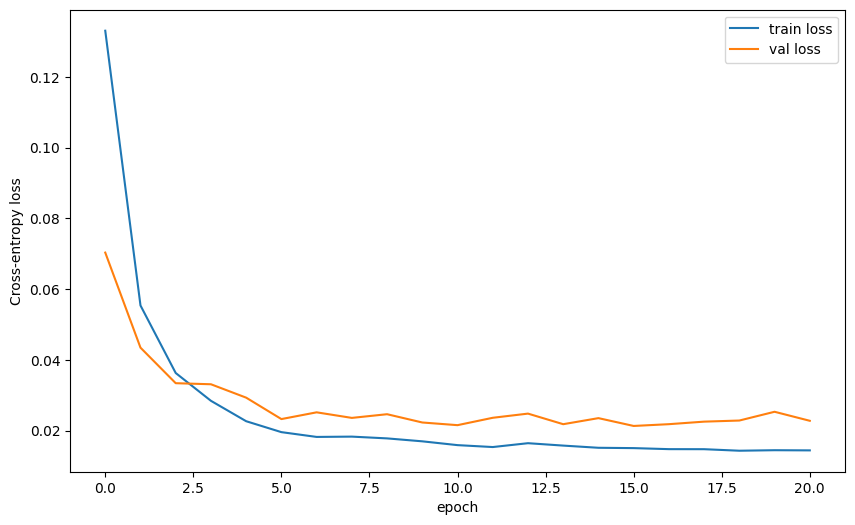

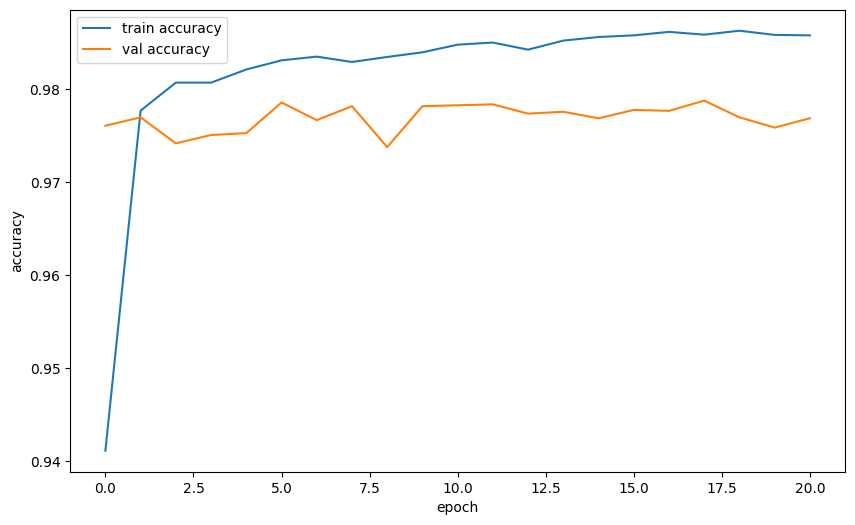

In [14]:
# Plot history loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel("epoch")
plt.ylabel("Cross-entropy loss")
plt.legend()
plt.show()

# Plot history accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()
plt.show()

## **Test and evaluate model**

In [15]:
best_model = keras.models.load_model(
    'models/best_model.keras',
    custom_objects={'TransformerEncoder': TransformerEncoder,
                    'PositionalEmbedding': PositionalEmbedding,
                    'GCNConv': GCNConv,
                    'GlobalSumPool': GlobalSumPool,
                    'GCN': GCN})

In [16]:
best_model.save('models/best_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [17]:
from sklearn.metrics import classification_report, confusion_matrix

In [18]:
y_pred_prob = model.predict([url_test, adjacency_test, feature_test])
y_pred = (y_pred_prob > 0.5).astype(int)
print(classification_report(label_test, y_pred))

313/313 [==============================] - 17s 52ms/step
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      5000
           1       0.99      0.97      0.98      5000

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



In [19]:
import numpy as np

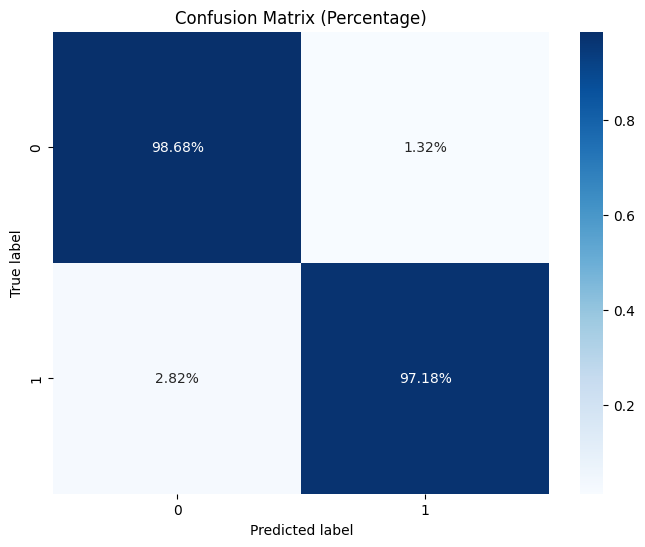

In [20]:
cm = confusion_matrix(label_test, y_pred)
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
sns.heatmap(cm_percentage, annot=True, fmt=".2%", cmap="Blues")
plt.title("Confusion Matrix (Percentage)")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()